# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

The most significant PCA dimensions are the directions of the highest variance in the data. Each PCA dimension will capture one or more feature/attribute of the untransformed dataset, such that the PCA dimension can "describe" the untransformed features that have these high variances. In this particular dataset, I think that the first PCA dimension will capture the "Fresh" product category, since the descriptive statistics in the README file shows that this category has the highest standard deviation.

I think the ICA dimensions will contain information about the individual demands of the groups of stores, in terms of how their purchasing amounts are distributed among the 6 categories. That could be a result of what kind (or category) of customers they are, whether they are specialty stores, or what geographic region the store is located, etc.

### PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6, whiten=True).fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_
#print sum(pca.explained_variance_ratio_[:4])

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer:

The first two components capture most of the variance at round 86%, with a very steep drop to the third component, which is only at around 7%. I'd use the first 2 components for the analysis, which is very simple to analyze. They seem to capture most of the variance in data at around 46% and 40.5%, values that are much higher than the rest of the components.

Analyzing the two dimensions is probably enough for this poject, in which we are trying to capture the different kinds of customer segments. We don't want to analyze with too much granular detail by including the much smaller components because we don't want very complicated types of clusters of segments with very special attributes, at least for now as we are trying to get a broad understanding of the groups of customers.

For image processing/compression projects, more components may need to be captured in order to maintain higher resolution of the images.

**3)** What do the dimensions seem to represent? How can you use this information?

(-0.25, 1)

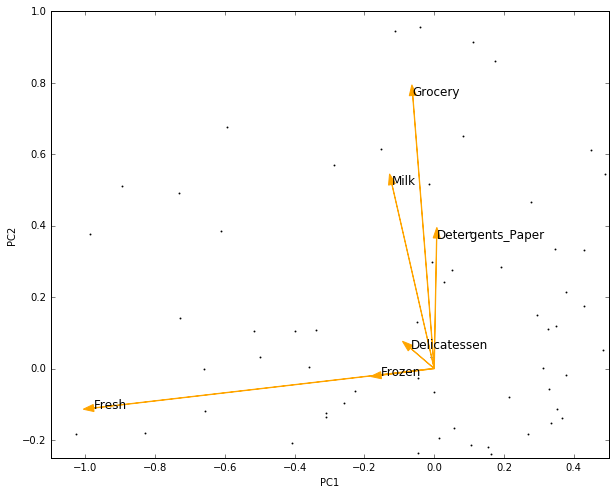

In [3]:
def biplot(df):
    # Fit on 2 components
    pca = PCA(n_components=2, whiten=True).fit(df)
    
    # Plot transformed/projected data
    ax = pd.DataFrame(
        pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(10, 8), s=0.8)

    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(
        zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='orange', ec='orange')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)

    return ax

ax = biplot(data)
ax.set_xlim([-1.1, .5])
ax.set_ylim([-.25, 1])
# ax.set_xlim([-4, 1])
# ax.set_ylim([-2, 4])

Answer:
The first principle component likely represents the clients' expenses on produce-type goods (vegetables and fruits), because it seems to measure how much the stores spend on "Fresh" products, and a small bit of how much they spend on "Frozen" and "Milk" products. The first dimension shows a strongly negative loading for "Fresh", with absolute value of almost 1, while the absolute value of the loadings corresponding to other attributes are much smaller ("Frozen" and "Milk" have the next 2 highest loadings). The fact that the first principle component captures these attributes shows that the amount spent by clients vary the most on "Fresh" products.

In the second dimension, "Grocery" has a very strongly positive loading, and there are moderately positive loadings for "Milk" and "Detergents_Paper". Loadings corresponding to "Fresh", "Frozen" and "Delicatessen" have very low magnitude, or are near zero. We can deduce that there are some correlations among the clients' expense on "Grocery", "Milk" and "Detergents_Paper" products, and that the second principle component captures the smaller grocery-type stores. 

In general, the loadings in the dimensions indicate that the clients' spending patterns on some of the product categories are correlated, and we can utilize this information to reduce the number of dimensions in the original data space by getting rid of highly correlated attributes, which might be important for some predictive modeling algorithms such as decision trees and random forests to prevent overfitting.

### ICA

In [4]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn import preprocessing

X_scaled = preprocessing.scale(data)
ica = FastICA(n_components=6, random_state=0).fit(X_scaled)

# Print the independent components
print ica.components_

[[ 0.00259749 -0.01304261  0.06424104  0.00176503 -0.00789576 -0.00472804]
 [ 0.0036662  -0.01675528 -0.11301178  0.00711535  0.13424464  0.01592772]
 [-0.00189529 -0.07279239  0.05444162  0.00183269 -0.01463357  0.01719393]
 [-0.05024607  0.00639506  0.00647498  0.00325086 -0.0104146   0.00291214]
 [-0.00485887 -0.00161266 -0.00552872 -0.00242502  0.0023066   0.05090388]
 [ 0.01091921  0.00104603 -0.00729797 -0.05405923  0.00256987  0.01686439]]


/Users/hqmac028/.virtualenvs/mlnd/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [5]:
# Scale each component
pd.DataFrame(np.apply_along_axis(lambda x: x/np.max(abs(x)), 1, ica.components_),
             columns=["Fresh",  "Milk",  "Grocery" , "Frozen",  "Detergents_Paper",  "Delicatessen"])
# Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.040434,-0.203026,1.000000,0.027475,-0.122908,-0.073598
1,0.027310,-0.124812,-0.841835,0.053003,1.000000,0.118647
2,-0.026037,-1.000000,0.747903,0.025177,-0.201032,0.236205
3,-1.000000,0.127275,0.128865,0.064699,-0.207272,0.057958
4,-0.095452,-0.031680,-0.108611,-0.047639,0.045313,1.000000
5,0.201986,0.019350,-0.135000,-1.000000,0.047538,0.311961


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 
Each of the vectors(rows) of the ICA decomposition correspond to a statistically independent attribute, which make up the individual "ingredients" that linearly combine with the weights to add up to the "super" attributes in the data we originally loaded from file. We can view these "ingredients" as a set of some hidden independent factors that causes each of the clients to spend a certain amount for a specific product category. Each column in the ICA components above correspond to weights for these "underlying factors". For example, a dot product with a given client's underlying factors and the first column in the ICA components shown above would result in the client's spending amount for "Fresh" products.

Using the scaled weights within each component/row, we can see that the first component has the maximum scaled weight in the "Grocery" category. It means that the first component corresponds to an independent hidden factor that causes customers to spend a lot on grocery products. It might mean that the hidden attribute stands for the category of small grocery stores.

The second component has maximum value at Detergents_Paper, and a very negative value for Grocery. This might indicate that it corresponds to a hidden attribute that represents the category of special stores that sell mostly detergents and paper-type products, perhaps like a small thrift store or CVS-type of store (if the hidden attribute is positive).

The third component has a very negative value for Milk, and somewhat positive value for grocery and a bit of deli foods. I can't really think of what category of stores this might pertain to, but I'd guess some small store that sells some food items but no milk. Maybe small stores attached to something, like remote gas stations?

The fourth component has a very negative value for the Fresh category, but it has pretty much even spending across the other categories, so it's probably a generic small store that doesn't carry much vegetables and fruits.

These types of categorizations can help us understand what kind of customers there are in the data, which will help us segment them based on the category. In the above, I assumed that the actual hidden attribute's values are all *positive* features, meaning larger positive values for that hidden feature indicates that the data point corresponds more to that customer category.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer:
K Means clustering and Gaussian Mixture Models are examples of unsupervised learning algorithms, where we can group data points without having any information about what category they belong to. By grouping these data points into clusters, we can determine some structure in the data, and deduce a labeling based on knowledge about the problem domain.

A big difference between the two algorithms is that GMM performs "soft clustering", which means that during the fitting process, it assigns a data point to a cluster with a probability. K means clustering assigns each data point to a cluster with absolute certainty (or prob = 1.0). In a sense, K means clustering is viewed as a specific type of GMMs.

An advantage of GMM over K means clustering is that GMMs can accommodate clusters that have different sizes and correlation structures, as opposed to K-means clustering, which only allows "spherical structures" of uniform sizes.
In parameter estimation, the GMM estimates the mean as well as the covariance matrix, whereas K means only estimates the mean. As a result, K means runs faster, and though technically the problem is considered NP-hard, heuristics used in practice are considered to have linear complexity.

Both K means clustering and GMMS are susceptible to local minimum under special cases, based on the starting initial values. A good way to get around that is to try different initial values to run the algorithms multiple times to see if the resulting clusters are the same/similar. Also, visualizing the resulting cluster boundaries can help determine whether the results are due to local optima.

For this project, it makes sense to use either K means clustering or GMMs since they both do what we need, which is to segment/cluster the customer data points. I think that there are only a few clusters (2 or 3) to consider based on the results of PCA, and therefore I'm not expecting a lot of clusters of various sizes and shapes. Therefore, I opted to go with K means clustering.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [6]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [7]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components=2, whiten=True).fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[-0.05066239  0.13161505]
 [ 0.34502287  0.33556674]
 [ 0.37738285  0.21406486]
 [-0.07718708 -0.5212911 ]
 [-0.83067886 -0.17928035]
 [ 0.2155776  -0.07967954]
 [ 0.05576966 -0.16710073]
 [ 0.34874672  0.11866355]
 [ 0.52313722 -0.18311407]
 [ 0.37595155  1.11903068]]


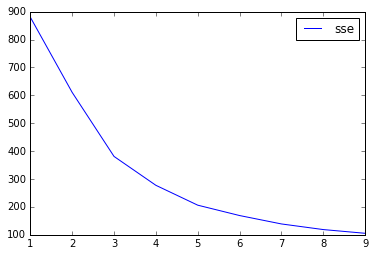

In [8]:
# Elbow method for choosing k

from sklearn.metrics.pairwise import euclidean_distances as dist

elbow_x = range(1, 10)
elbow_y = []
for _k in elbow_x:
    clusters = KMeans(n_clusters=_k).fit(reduced_data)
    centers = clusters.cluster_centers_
    labels = clusters.labels_
    # Find SSE
    _sse = 0
    for _l in range(_k):
        # data points corresponding to label _l
        for _point in reduced_data[np.where(labels==_l)]:
            _sse += dist(np.array(_point).reshape(1, -1),
                         np.array(centers[_l]).reshape(1, -1),
                         squared=True)
    elbow_y.append(_sse[0][0])
    
elbow = pd.DataFrame({'sse': elbow_y})
elbow.index = elbow_x
elbow.plot()

Using the "Elbow method", based on this plot, it looks like there are 3 clusters in the data

In [9]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=3, random_state=0).fit(reduced_data)
print clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)


In [10]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [11]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.cluster_centers_
print centroids

[[ 0.32398252 -0.25421161]
 [ 0.10439573  2.12063212]
 [-1.86890029 -0.36902956]]


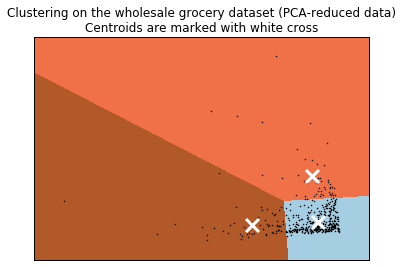

In [12]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

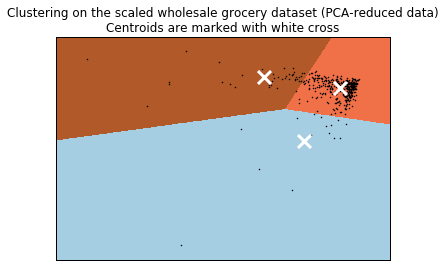

In [14]:
# Cluster plot of scaled data

reduced_data = PCA(n_components=2, whiten=True).fit_transform(X_scaled)
clusters = KMeans(n_clusters=3, random_state=0).fit(reduced_data)

# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the scaled wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

To determine that there are 3 clusters, I used the "Elbow Method", where I plotted out the SSE (total sum of squared distance of the data points in each cluster to the corresponding centroid) vs the number of clusters. By doing this we can look for points where significant drops in the SSE values suddenly become gradual, meaning that the value of having another cluster becomes reduced.

Looking at the **unscaled** cluster plot above, having 3 clusters makes sense because most of the customers seem to lie in the bottom right, where they spend relatively similar amounts for categories of products corresponding to principle components 1 and 2. The other two clusters are sort of the "extreme" segments, where they might spend more or less on certain categories. (The **scaled** cluster plot above shows the clusters of the data using the scaled version of the original data to visualize the clusters in a more "spread-out" view)

The central objects in each cluster are the most average/typical customer within that cluster, with respect to their expenses in the products categories corresponding to principle components 1 and 2. For example, if the left cluster in brownish orange represents the group of customers who tend to spend very little on produce-type products, then the central object in that cluster represents a typical customer who spends very little on that product. In trying to understand the 3 clusters of customers, the distributor can picture customers located closest to the central objects as the most typical customers for each cluster. For example, for the left cluster, we can imagine stores like CVS, where they don't have a lot of fruits and vegetables. For the top cluster, maybe stores like Ralphs, where they sell grocery-type foods, as well as Milk and non-food products like detergents and paper. The bottom right cluster might be smaller stores who dont really specialize in any of the categories above, like local food stores.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

I think PCA and the biplots gave me a very good understanding of the customers' expense patterns with respect to the different types of products. The cluster analysis in the end helped me see how the different groups of customers cluster, so that it essentially completes the objective of this assigment, which is to segment the customers. The visualizations of the clusters in the same space as the biplots (principle components 1 and 2 for x and y axes, respectively) was especially helpful for me to understand how the customers group together. I think the combination of the two are very useful and insightful for these types of projects.

ICA is interesting in its own way, but it was difficult for me to gain any tangible understanding of what the values of the components represent for this dataset.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

PCA and clustering can be used to perform other types of analyses besides customer spending, such as customer feedback data, customer complaints, returns and even something more dynamic, like changes in the number of orders over time. By grouping clients based on any data that the distributor has on them, we can run analyses to gain insights about the customers.

For example, by doing PCA and clustering on the client's changes in the number of orders, we might be able to find a group of clients who are ordering less milk, compared to the year before. In that case, even if there are hundreds of customers in that category, just talking to a couple of them might reveal that there's a new milk distributor who is selling for a lot less, so our client distributor can go ahead and adjust prices accordingly to be more competitive.

**10)** How would you use that data to help you predict future customer needs?

Answer: After running the techniques and having the various clusters of the customers available, experiments can be designed in order to see whether there will be a large impact on the business as a whole. For experiments like changing delivery times as explained in the project description, it would be prudent to sample a few stores from each of the clusters to do the tests before concluding that there aren't any harmful effects of making the change. It might also be good idea to spread out the customer samples in each cluster, and to include customers near the centers of each cluster, so as to get a very broad range of responses.

Another thing to consider is to do A/B testing, where new service changes like delivery time changes are applied to some stores within a category, and the rest of the category are left unchanged. Then it's possible to analyze the results to compare how the change affects the companies in a given category, which might be smart to do before implementing it in all the stores in the category.

Also, when problems or specific needs arise from customers in a particular group, based on the cluster they belong to, it may be easy to see patterns. For example, if several customers in one cluster are asking if the distributor carries a new product, the distributor can go ask the rest of the customers who haven't requested the new products to see if they might want them also, and it's possible that they would want it. These types of insights can increase sales and revenue for the distributor, so everybody wins.

Lastly, now that we have a segment label for each of the customers, we can use the labels to create supervised learning models, such that the target variable is the segment that the customers belong to. This is userful if we we want to train classifiers, so that when new customer accounts come in, we can easily identify which segment the customer belongs to and provide the approprite kind of service to them.